### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *
import sqlite3
from sqlite3 import Error

In [3]:
database_dir = '/home/Assignment/02_training_pipeline/notebooks/'
#database_dir = root_dir + 'Data'

 ### 2 Reading Data

In [4]:
%%time
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 302 ms, sys: 64.3 ms, total: 366 ms
Wall time: 364 ms


In [5]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [6]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [7]:
def create_sqlit_connection(db_path,db_file):
    """ create a database connection to a SQLite database """
    conn = None
    # opening the conncetion for creating the sqlite db
    try:
        conn = sqlite3.connect(db_path+db_file)
        print(sqlite3.version)
    # return an error if connection not established
    except Error as e:
        print(e)
    # closing the connection once the database is created
    finally:
        if conn:
            conn.close()

In [8]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebook/' location

create_sqlit_connection(database_dir, r"lead_scoring_model_experimentation.db")

2.6.0


In [9]:
# starting mlflow server (execute the below line in terminal) (terminal: File >> New >> terminal)
# mlflow server --backend-store-uri='sqlite:////home/Assignment/02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="/home/Assignment/mlruns/" --port=6007 --host=0.0.0.0

In [10]:
# create a mlflow tracking uri at "http://0.0.0.0:6007"
mlflow.set_tracking_uri("http://0.0.0.0:6007")

In [11]:
# setup pycaret 
# No Pre-Processing 
Baseline_model_exp01 = setup(data = dataset, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Baseline_model_exp01',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


2022/10/24 10:23:45 INFO mlflow.tracking.fluent: Experiment with name 'Baseline_model_exp01' does not exist. Creating a new experiment.


### 4 : Model Experimentation with pycaret

In [13]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5, exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada']) #

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7386,0.8211,0.8317,0.7029,0.7619,0.4766,0.4849,0.5600
lightgbm,Light Gradient Boosting Machine,0.7385,0.8211,0.8343,0.7020,0.7624,0.4765,0.4854,4.4620
et,Extra Trees Classifier,0.7367,0.8176,0.8210,0.7044,0.7582,0.4729,0.4797,3.6120
dt,Decision Tree Classifier,0.7364,0.8166,0.8205,0.7041,0.7579,0.4723,0.4789,0.5700
rf,Random Forest Classifier,0.7346,0.8169,0.8394,0.6957,0.7608,0.4686,0.4791,1.3100
lr,Logistic Regression,0.7098,0.7837,0.8222,0.6731,0.7402,0.4189,0.4297,0.2380
ridge,Ridge Classifier,0.7005,0.0000,0.7962,0.6702,0.7278,0.4003,0.4077,0.1700
lda,Linear Discriminant Analysis,0.7005,0.7733,0.7961,0.6702,0.7277,0.4003,0.4077,0.9540
nb,Naive Bayes,0.6629,0.7335,0.8924,0.6134,0.7269,0.3241,0.3653,0.1940


In [14]:
# create a model which gives the highest accuracy
lbgm  = create_model('lightgbm', fold = 5) 

In [15]:
lbgm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

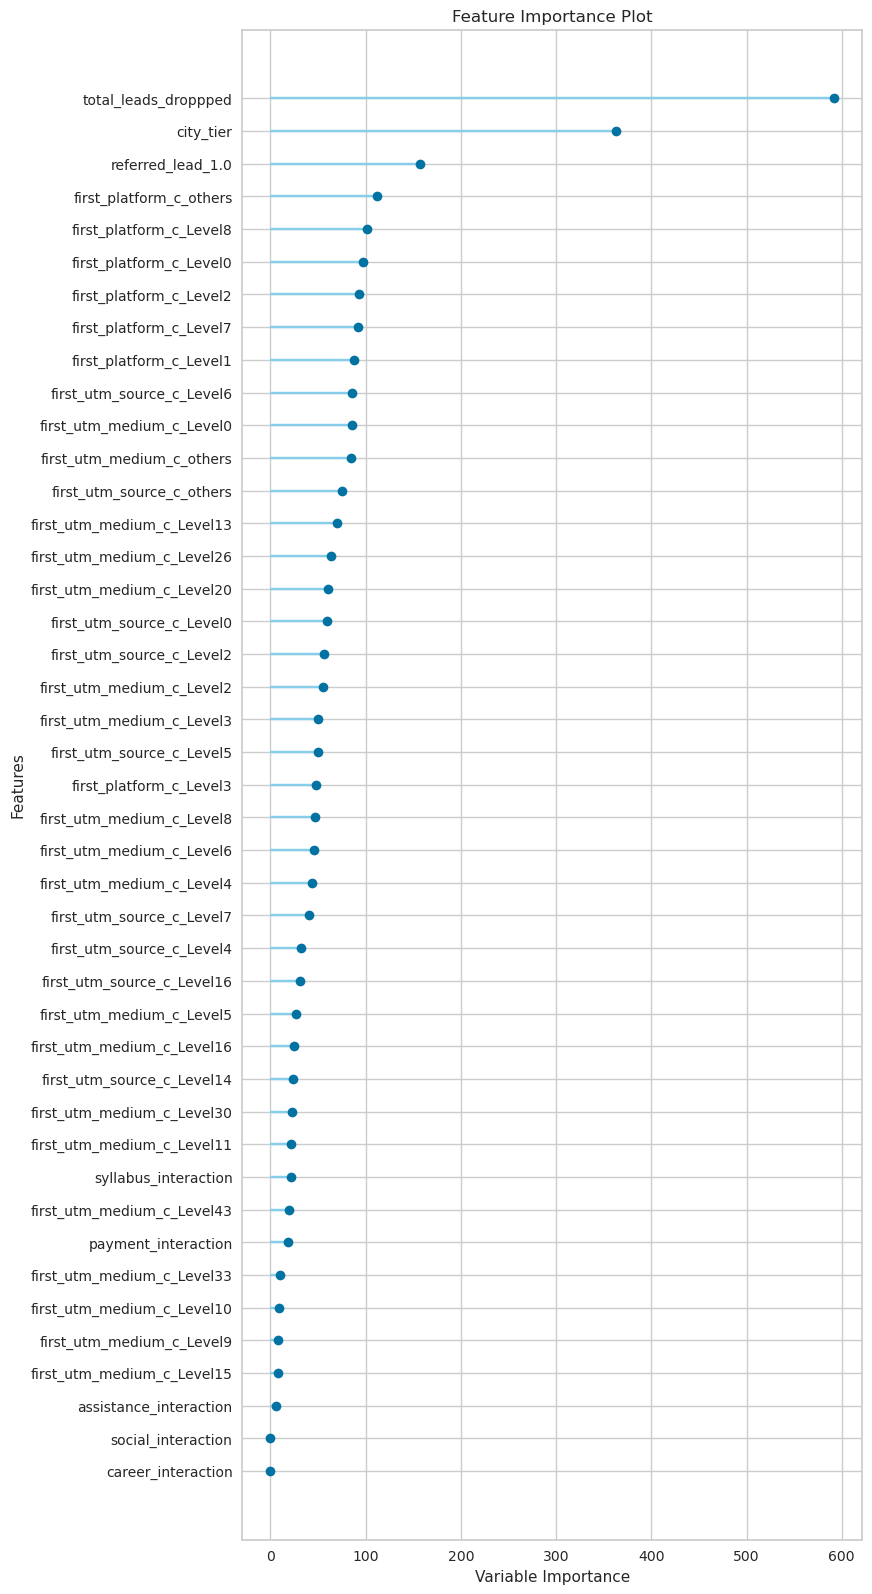

In [16]:
# create feature importance plot
#top 10 features
plot_model(lbgm, plot='feature_all') #feature_all -> to check for all features 

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [17]:
dataset_final = dataset[['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']]

In [18]:
dataset_final

,total_leads_droppped,city_tier,referred_lead,app_complete_flag,first_platform_c,first_utm_medium_c,first_utm_source_c
0,1.0,1.0,0.0,1,Level0,Level11,Level2
1,1.0,2.0,0.0,1,Level3,Level0,others
2,1.0,1.0,0.0,1,Level3,Level0,Level0
3,2.0,1.0,0.0,0,Level1,Level3,others
4,1.0,1.0,0.0,0,Level3,Level0,Level0
...,...,...,...,...,...,...,...
238959,1.0,1.0,0.0,1,Level3,Level0,Level0
238960,2.0,1.0,0.0,1,Level7,Level11,Level2
238961,2.0,2.0,0.0,1,Level0,Level4,Level2
238962,3.0,2.0,0.0,1,Level0,Level6,Level7


In [19]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.
Baseline_model_exp02 = setup(data = dataset_final, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Baseline_model_exp02',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False,
                   normalize = False ,  transformation = False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


2022/10/24 10:28:28 INFO mlflow.tracking.fluent: Experiment with name 'Baseline_model_exp02' does not exist. Creating a new experiment.


In [20]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(fold = 5, exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada']) #

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7385,0.8210,0.8342,0.7020,0.7624,0.4765,0.4853,4.2160
xgboost,Extreme Gradient Boosting,0.7384,0.8209,0.8303,0.7031,0.7614,0.4762,0.4843,0.5660
et,Extra Trees Classifier,0.7366,0.8174,0.8211,0.7042,0.7582,0.4727,0.4795,3.3660
dt,Decision Tree Classifier,0.7363,0.8166,0.8205,0.7041,0.7578,0.4722,0.4788,0.5020
rf,Random Forest Classifier,0.7350,0.8178,0.8432,0.6949,0.7619,0.4693,0.4805,1.3060
lr,Logistic Regression,0.7097,0.7835,0.8222,0.6730,0.7402,0.4187,0.4295,0.2200
ridge,Ridge Classifier,0.7002,0.0000,0.7959,0.6700,0.7275,0.3998,0.4072,0.1680
lda,Linear Discriminant Analysis,0.7002,0.7726,0.7959,0.6700,0.7275,0.3998,0.4072,0.8480
nb,Naive Bayes,0.6701,0.7337,0.8568,0.6255,0.7231,0.3387,0.3650,0.1900


In [21]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
# create a model which gives the highest accuracy
lbgm  = create_model('lightgbm', fold = 5) 

In [22]:
lbgm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [23]:
pip install optuna

     |████████████████████████████████| 348 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 41.6 MB 134 kB/s eta 0:00:011
     |████████████████████████████████| 50 kB 7.9 MB/s  eta 0:00:01
     |████████████████████████████████| 147 kB 9.9 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 10.5 MB/s eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=d8b1a33f8406123dee1110bba3066e7c7df5f134d2e3774812ef75bed52b863d
  Stored in directory: /home/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.3
    Uninstalling scipy-1.5.3:
      Successfully uninstalled scipy-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the follow

In [24]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
tuned_lgbm_optuna,tuner = tune_model(lbgm, 
                                    search_library='optuna',
                                    search_algorithm='random',
                                    fold = 10,
                                    optimize = 'AUC',
                                    choose_better=True,
                                    return_tuner=True)

In [25]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuner)

OptunaSearchCV(callbacks=None,
               cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
               enable_pruning=False, error_score='raise',
               estimator=Pipeline(memory=None,
                                  steps=[('empty_step', 'passthrough'),
                                         ('actual_estimator',
                                          LGBMClassifier(boosting_type='gbdt',
                                                         class_weight=None,
                                                         colsample_bytree=1.0,
                                                         device='gpu',
                                                         importance_type='split',
                                                         learning_rate=0....
                                    'actual_estimator__reg_alpha': FloatDistribution(high=10.0, log=True, low=1e-10, step=None),
                                    'actual_estimator__

In [26]:
print(tuned_lgbm_optuna)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
